In [ ]:
#Step 0. load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.inspection import permutation_importance



- **Source**: Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340

In [ ]:
#Step 1. Load data
url = "/content/skbr_cells.csv"
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [ ]:
df_raw.sample(10, random_state=2025)

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1526,208336841,Train,WS,148.157960,308,118.761905,197.187075,70.027211,112.697279,1.065898,...,34916,57680,20588,33133,48.976509,156.199809,104.811623,18.749445,460,188
1551,208396157,Test,PS,10.346789,242,58.722944,6.909091,77.497835,3.194805,1.231397,...,13565,1366,17902,738,68.858858,171.501111,3.662276,15.203546,201,399
552,208312454,Test,PS,109.824389,160,61.143791,4.712418,147.366013,34.052288,1.167683,...,9355,569,22547,5210,37.426777,91.057243,46.012188,12.061842,216,163
1956,208935209,Train,PS,164.907580,153,25.719178,115.417808,26.904110,86.863014,1.179153,...,3755,16706,3928,12682,16.221389,26.463293,58.400909,11.939754,269,107
135,208406905,Test,WS,143.244805,246,23.834043,246.068085,10.506383,43.165957,1.097487,...,5601,57592,2469,10144,17.349784,25.911859,66.686581,15.969757,494,64
571,208405358,Test,PS,111.650507,293,37.342857,4.432143,83.782143,54.010714,1.413115,...,10456,962,23459,15123,21.287747,43.671653,69.855283,9.123565,114,236
325,208410525,Test,WS,83.976225,316,39.970199,140.996689,47.619205,66.612583,1.089897,...,12071,42280,14381,20117,28.215745,47.378328,65.185463,13.399715,275,84
723,208406924,Test,PS,108.271419,563,20.990706,62.881041,25.752788,13.386617,1.595038,...,11293,33293,13855,7202,17.458658,33.273512,28.350160,27.449929,387,152
1056,208396138,Train,PS,19.550427,412,214.098985,328.918782,238.106599,446.873096,1.136391,...,84355,129201,93814,176068,164.607880,321.653823,376.531983,22.847778,111,303
411,208397497,Train,PS,86.122381,310,95.827703,136.952703,171.847973,568.989865,1.124491,...,28365,40243,50867,168421,54.252295,137.681847,361.835294,16.429758,210,307


In [ ]:
#Step 2. Preprocessing
df_baking = df_raw.copy()

df_baking.columns = df_baking.columns.str.lower()
df_baking = df_baking[['perimch1','eqsphereareach1','entropyintench1','class']]
df_baking = df_baking.drop_duplicates()
df_baking['class'] = df_baking['class'].astype('category')

df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   perimch1         2019 non-null   float64 
 1   eqsphereareach1  2019 non-null   float64 
 2   entropyintench1  2019 non-null   float64 
 3   class            2019 non-null   category
dtypes: category(1), float64(3)
memory usage: 49.5 KB


In [ ]:
#Step 3 EDA

df_train, df_test = train_test_split(df, test_size=0.2, random_state=2025, stratify=df['class'])
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_test.shape

((1615, 4), (404, 4))

In [ ]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
perimch1,1615.0,89.878828,41.682705,47.489176,64.015648,77.149514,99.197799,459.765378
eqsphereareach1,1615.0,1278.413006,841.824173,603.755102,775.657596,1002.065760,1454.882086,8746.063492
entropyintench1,1615.0,6.574064,0.746037,4.707829,6.022178,6.573556,7.031053,9.475700


,count,unique,top,freq
class,1615,2,PS,1040


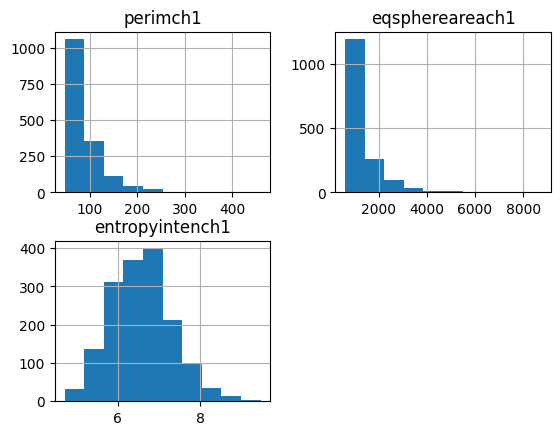

In [ ]:
df_train.hist()
plt.show()

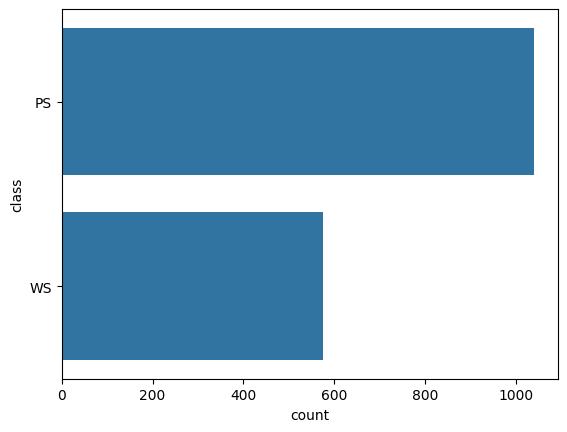

In [ ]:
sns.countplot(df_train, y='class')
plt.show()

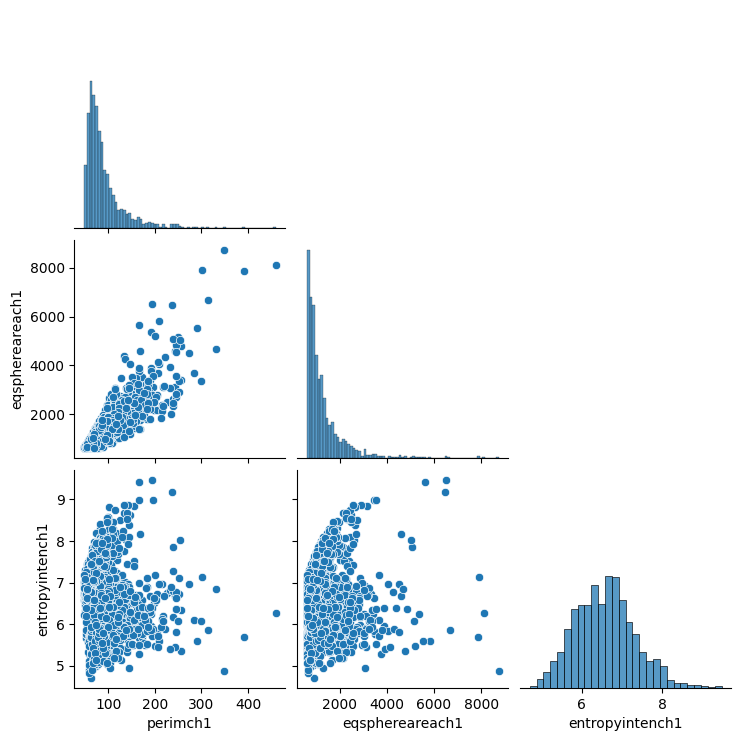

In [ ]:
sns.pairplot(df_train, corner=True)
plt.show()

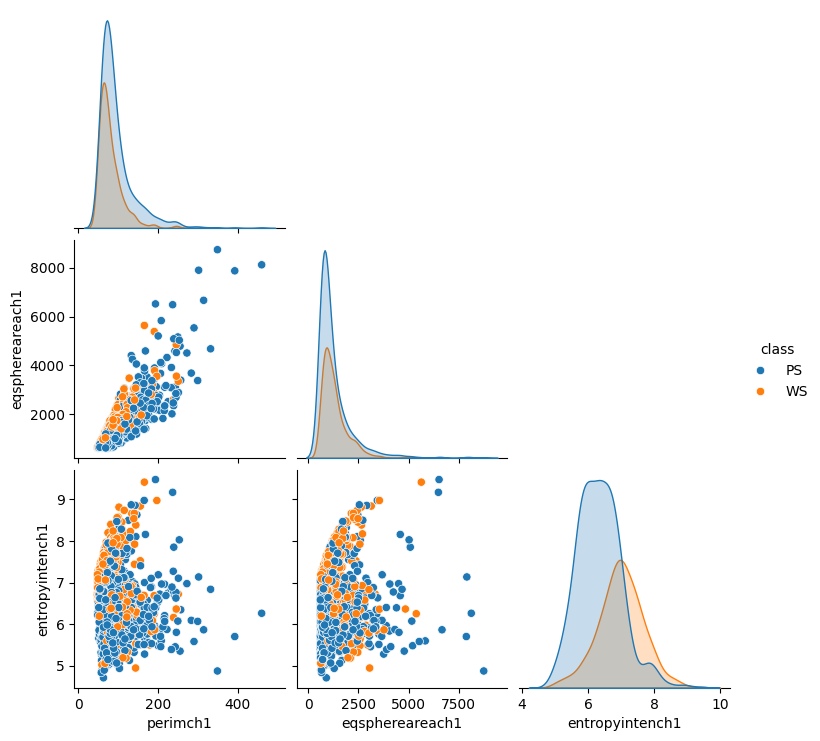

In [ ]:
sns.pairplot(df_train, corner=True, hue='class')
plt.show()

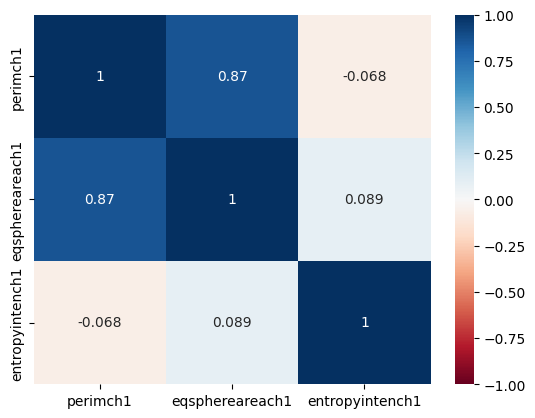

In [ ]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

In [ ]:
#Step 4 ML
X_train = df_train.drop(columns='class')
y_train = df_train['class']

X_test = df_test.drop(columns='class')
y_test = df_test['class']

X_test.shape, y_train.shape

((404, 3), (1615,))

In [ ]:
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

In [ ]:
tree_clf = DecisionTreeClassifier(class_weight='balanced', random_state=2025)
tree_clf.fit(X_train, y_train_enc)
y_pred = tree_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_pred):.2f}')

Accuracy: 0.71


              precision    recall  f1-score   support

          PS       0.75      0.81      0.78       260
          WS       0.60      0.52      0.56       144

    accuracy                           0.71       404
   macro avg       0.68      0.66      0.67       404
weighted avg       0.70      0.71      0.70       404



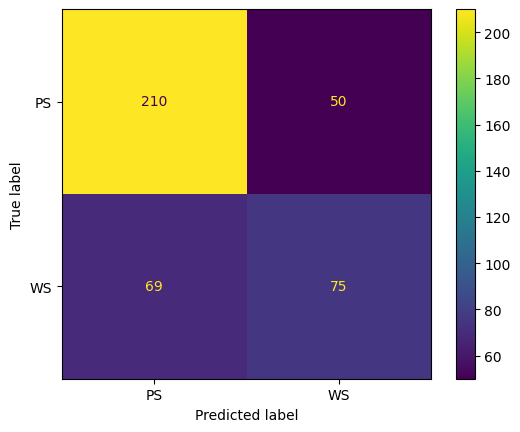

In [ ]:
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred, display_labels=encoder.classes_)
plt.show()

In [ ]:
tree_clf_cv = GridSearchCV(
    tree_clf,
    param_grid={
        'max_depth':[1,2,3,4,5,6,7],
        'min_samples_leaf':[2,4,6]
    },
    cv = 5
)
#Con este algoritmo buscamos los mejores parametros de tree decision
tree_clf_cv.fit(X_train, y_train_enc)
tree_clf_cv.best_params_

{'max_depth': 6, 'min_samples_leaf': 6}

              precision    recall  f1-score   support

          PS       0.85      0.72      0.78       260
          WS       0.61      0.77      0.68       144

    accuracy                           0.74       404
   macro avg       0.73      0.75      0.73       404
weighted avg       0.76      0.74      0.75       404



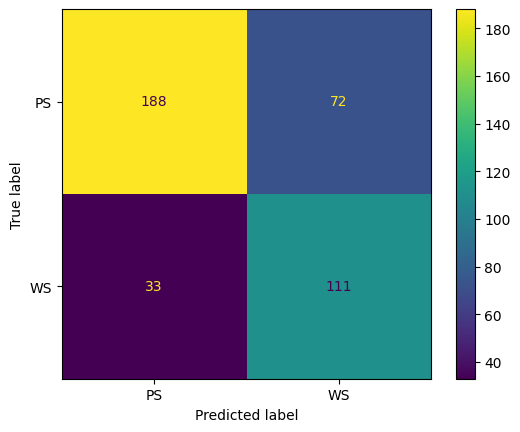

In [ ]:
y_pred = tree_clf_cv.predict(X_test)
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred, display_labels=encoder.classes_)
plt.show()

              precision    recall  f1-score   support

          PS       0.78      0.87      0.82       260
          WS       0.70      0.56      0.63       144

    accuracy                           0.76       404
   macro avg       0.74      0.72      0.72       404
weighted avg       0.75      0.76      0.75       404



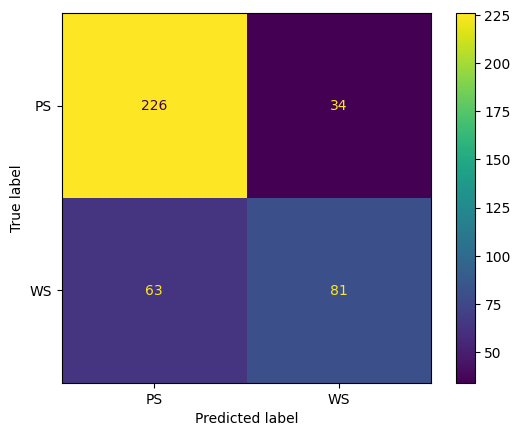

In [ ]:
r_forest_clf = RandomForestClassifier(class_weight='balanced',random_state=2025)
r_forest_clf.fit(X_train, y_train_enc)
y_hat = r_forest_clf.predict(X_test)


print(classification_report(y_test_enc, y_hat, target_names=encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat, display_labels=encoder.classes_)
plt.show()

In [ ]:
r_forest_clf_cv = GridSearchCV( #Numero de combinaciones de busqueda = 7x3x3, es decir la cantidad de elementos que tiene nuestro paramgrid
    r_forest_clf,
    param_grid={
        'max_depth':[1,2,3,4,5,6,7], #7
        'n_estimators':[50,100,150], #3
        'min_samples_split':[2,4,6] #3
    },
    cv = 5
)
#Con este algoritmo buscamos los mejores parametros de tree decision
r_forest_clf_cv.fit(X_train, y_train_enc)
r_forest_clf_cv.best_params_

{'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}

              precision    recall  f1-score   support

          PS       0.84      0.81      0.82       260
          WS       0.67      0.72      0.69       144

    accuracy                           0.77       404
   macro avg       0.75      0.76      0.76       404
weighted avg       0.78      0.77      0.78       404



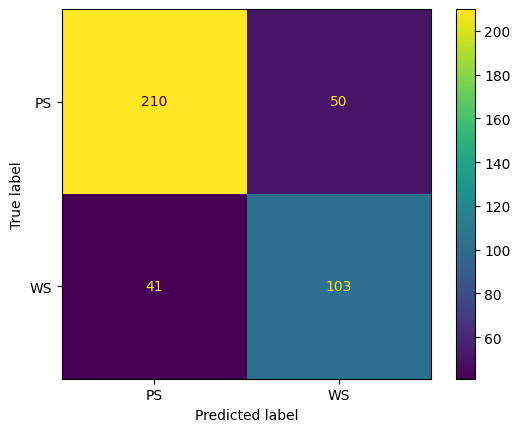

In [ ]:
y_hat = r_forest_clf_cv.predict(X_test)
print(classification_report(y_test_enc, y_hat, target_names=encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat, display_labels=encoder.classes_)
plt.show()

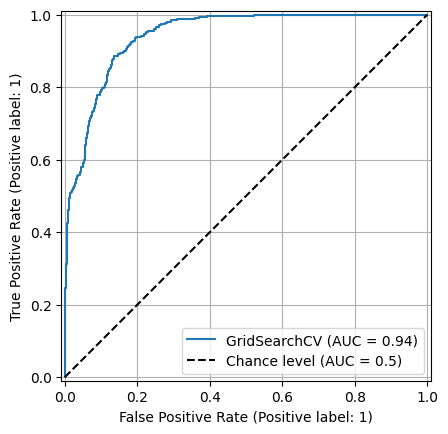

In [ ]:
y_hat_best_score = r_forest_clf_cv.best_estimator_.predict_proba(X_test)[:1]
RocCurveDisplay.from_estimator(
    r_forest_clf_cv, X_train, y_train_enc, plot_chance_level=True
)
plt.grid(True)
plt.show()

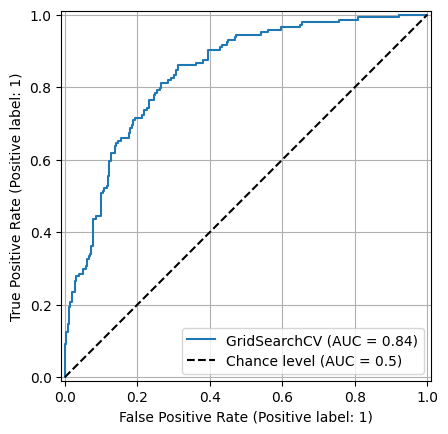

In [ ]:
RocCurveDisplay.from_estimator(
    r_forest_clf_cv, X_test, y_test_enc, plot_chance_level=True
)
plt.grid(True)
plt.show()

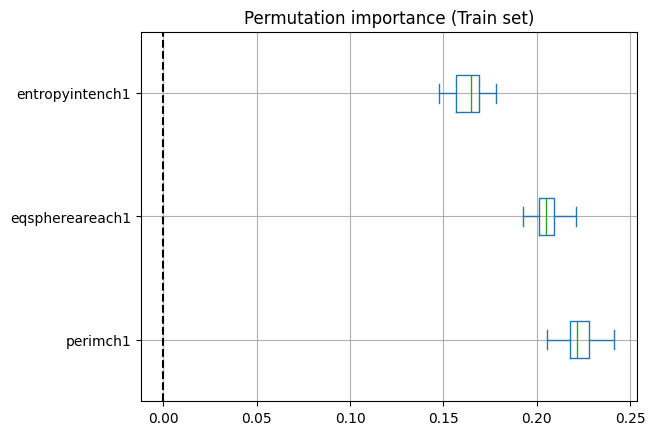

In [ ]:
importance = permutation_importance(r_forest_clf_cv, X_train, y_train_enc, n_repeats=25, random_state=2025)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)

ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title("Permutation importance (Train set)")
ax.grid(True)
plt.show()